In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import glob
from re import T
from sympy import *
from scipy.spatial.transform import Rotation

In [2]:
# for direct kinematics

alpha1, alpha2, alpha3, alpha4, alpha5, alpha6 = symbols('alpha1:7')
a1, a2, a3, a4, a5, a6 = symbols('a1:7')
d1, d2, d3, d4, d5, d6 = symbols('d1:7')
q1, q2, q3, q4, q5, q6 = symbols('q1:7')


def set_dh_table():
    dh_subs_dict = {alpha1: pi / 2, a1: 0, d1: 0.2433, q1: q1,
                    alpha2: pi, a2: 0.28, d2: 0.03, q2: q2 + pi / 2,
                    alpha3: pi / 2, a3: 0, d3: 0.02, q3: q3 + pi / 2,
                    alpha4: pi / 2, a4: 0, d4: 0.245, q4: q4 + pi / 2,
                    alpha5: pi / 2, a5: 0, d5: 0.057, q5: q5 + pi,
                    alpha6: 0, a6: 0, d6: 0.235, q6: q6 + pi / 2}
    return dh_subs_dict

def dh(alpha, a, d, theta):
    # Formula
    return Matrix([[cos(theta), -cos(alpha)*sin(theta), sin(alpha)*sin(theta), a*cos(theta)],
                     [sin(theta), cos(alpha)*cos(theta), -sin(alpha)*cos(theta), a*sin(theta)],
                     [0, sin(alpha), cos(alpha), d],
                     [0, 0, 0, 1]])               

    
def transform_matrices():

    dictionary = set_dh_table()
    T_01 = dh(dictionary[alpha1], dictionary[a1], dictionary[d1], dictionary[q1])
    T_12 = dh(dictionary[alpha2], dictionary[a2], dictionary[d2], dictionary[q2])
    T_23 = dh(dictionary[alpha3], dictionary[a3], dictionary[d3], dictionary[q3])
    T_34 = dh(dictionary[alpha4], dictionary[a4], dictionary[d4], dictionary[q4])
    T_45 = dh(dictionary[alpha5], dictionary[a5], dictionary[d5], dictionary[q5])
    T_56 = dh(dictionary[alpha6], dictionary[a6], dictionary[d6], dictionary[q6])
    Tes = Matrix([[0, -1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    T = T_01 * T_12 * T_23 * T_34 * T_45 * T_56 * Tes

    return T

def FK(theta_list):

    dictionary = set_dh_table()
    T_01 = dh(dictionary[alpha1], dictionary[a1], dictionary[d1], dictionary[q1])
    T_12 = dh(dictionary[alpha2], dictionary[a2], dictionary[d2], dictionary[q2])
    T_23 = dh(dictionary[alpha3], dictionary[a3], dictionary[d3], dictionary[q3])
    T_34 = dh(dictionary[alpha4], dictionary[a4], dictionary[d4], dictionary[q4])
    T_45 = dh(dictionary[alpha5], dictionary[a5], dictionary[d5], dictionary[q5])
    T_56 = dh(dictionary[alpha6], dictionary[a6], dictionary[d6], dictionary[q6])
    Tes = Matrix([[0, -1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    T = T_01 * T_12 * T_23 * T_34 * T_45 * T_56 * Tes

    theta_dict = {q1:theta_list[0], q2:theta_list[1], q3:theta_list[2], q4:theta_list[3], q5:theta_list[4], q6:theta_list[5]}

    T_0G_eval = T.evalf(subs=theta_dict, chop=True, maxn=4)
    A = T_0G_eval
    A03 = np.array(A[0, 3]).astype(np.float32)
    A13 = np.array(A[1, 3]).astype(np.float32)
    A23 = np.array(A[2, 3]).astype(np.float32)
    return np.array([A03, A13, A23])


In [3]:
#data_path = set your own path to data dir
data_path = 'C:/Users/alon/Repose/robotics_kinova_lab/Lab4/data_lab4'
real_path = []
for file in glob.glob(data_path + '/*/*.pkl'):
    with open(file, 'rb') as h:
        real_path.append(pickle.load(h))

In [4]:
def plot_xyz(Key_points, r_path, p_path, num):

    fig = plt.figure(figsize = (55,20))
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.scatter(Key_points[:,0],Key_points[:,1], Key_points[:,2], c='red', s=10) 
    ax1.plot(r_path[:,0], r_path[:,1], r_path[:,2], color='black')
    ax1.plot(p_path[:,0], p_path[:,1], p_path[:,2], color='blue', linestyle='dashed')
    ax1.legend(['Real path','Planned path', 'Key points'])
    ax1.set_xlabel('X[m]')
    ax1.set_ylabel('Y[m]')
    ax1.set_zlabel('Z[m]')
    ax1.set_title(f"XYZ Gripper path, {num}")

    # plt.savefig(f"C:/Users/alon/Repose/robotics_kinova_lab/Lab4/figs/{num}.png")

    plt.show()

In [5]:
def traj_gen_config(q1, q2, t, Tf):
    """    
    B.C: q(0) = q1; q_dot(0) = 0; q(Tf) = q2; q_dot(Tf) = 0; 
    """
    a0 = q1
    a1 = 0.
    a2 = (3 / (Tf ** 2)) * (q2 - q1)
    a3 = (2 / (Tf ** 3)) * (q1 - q2)
    q = a0 + a1 * t + a2 * (t ** 2) + a3 * (t ** 3)
    dq = a1 + 2 * a2 * t + 3 * a3 * (t ** 2)
    ddq = 2 * a2 + 6 * a3 * t
    
    '''
    linear: a0 = q1 ; a1 = (q2 - q1) / Tf ; q = a0 + a1 * t ; dq = a1 ; ddq = 0;
    '''
    return q, dq, ddq

def traj_gen_task(x_s, x_g, t, Tf):
    a0 = x_s
    a1 = 0.
    a2 = (3 / (Tf ** 2)) * (x_g - x_s)
    a3 = (2 / (Tf ** 3)) * (x_s - x_g)
    x = a0 + a1 * t + a2 * (t ** 2) + a3 * (t ** 3)
    dx = a1 + 2 * a2 * t + 3 * a3 * (t ** 2)
    ddx = 2 * a2 + 6 * a3 * t
    return x, dx, ddx
    
def traj_gen_task_L(x_s, x_g, t, Tf):
    a0 = x_s
    a1 = (x_g - x_s) / Tf 
    x = a0 + a1 * t
    dx = a1
    ddx = 0
    return x, dx, ddx

In [6]:
### rec 1 
x_1 = np.array([[0.415, 0.335, 0.615, 90.4, 0.1, 166],
                [0.445, -0.057, 0.281, 169.759, 0.238, 95.399],
                [0.434, -0.049, 0.006, 175.89, 0.755, 93.778],
                [0.467, -0.224, 0.159, 81.521, -0.95, 108.473]])

jointPoses_1 = np.array([[22.41, 319.858, 358.647, 329.983, 291.341, 57.045],
                        [0.962, 325.185, 45.99, 270.511, 271.036, 85.574],
                        [2.779, 304.625, 76.142, 269.026, 315.635, 89.646],
                        [308.182, 290.667, 68.802, 20.536, 276.567, 310.149]])

### rec 2
x_2 = np.array([[0.44, 0.187, 0.419, 96, 1, 150],
                [0.463, -0.131, 0.298, 99.211, -175.981, 99.796],
                [0.634, -0.14, 0.297, 87.317, -177.205, 92.726],
                [0.305, 0.403, 0.53, 105.716, -159.563, 171.653]])

jointPoses_2 = np.array([[0.1, 343, 75, 354, 300, 0.1],
                        [334.71, 325.18, 122.117, 234.212, 80.389, 279.347],
                        [347.508, 311.931, 77.55, 243.598, 35.784, 288.416],
                        [37.575, 340.48, 90.23, 211.41, 59.793, 304.981]])               

In [7]:
Tf = 3
N = 18
t = np.linspace(0, Tf, N)
#TS
planned_path_1 = []
planned_path_1_L = []
planned_path_2 = []
#CS
Cplanned_path_1 = []
Cplanned_path_1_L = []
Cplanned_path_2 = []

# Desired path 1
for i in range(3):  
    for t1 in t:
        x1, dx1, ddx1 = traj_gen_task(x_1[i,:], x_1[i + 1,:], t1, Tf)
        planned_path_1.append(x1)
        x1L, dx1L, ddx1L = traj_gen_task_L(x_1[i,:], x_1[i + 1,:], t1, Tf)
        planned_path_1_L.append(x1L)
        q11, dq1, ddq1 = traj_gen_task(jointPoses_1[i,:], jointPoses_1[i + 1,:], t1, Tf)
        q11 = FK(np.deg2rad(q11))
        Cplanned_path_1.append(q11)
        q1L, dq1L, ddq1L = traj_gen_task_L(jointPoses_1[i,:], jointPoses_1[i + 1,:], t1, Tf)
        q1L = FK(np.deg2rad(q1L))
        Cplanned_path_1_L.append(q1L)
planned_path_1 = np.array(planned_path_1)
planned_path_1_L = np.array(planned_path_1_L)
Cplanned_path_1 = np.array(Cplanned_path_1)
Cplanned_path_1_L = np.array(Cplanned_path_1_L)

# Desired path 2 
for j in range(3):  
    for t2 in t:
        x2, dx2, ddx2 = traj_gen_task(x_2[j,:], x_2[j + 1,:], t2, Tf)
        planned_path_2.append(x2)
        q22, dq2, ddq2 = traj_gen_task(jointPoses_2[j,:], jointPoses_2[j + 1,:], t2, Tf)
        q22 = FK(np.deg2rad(q22))
        Cplanned_path_2.append(q22)
planned_path_2 = np.array(planned_path_2)
Cplanned_path_2 = np.array(Cplanned_path_2)


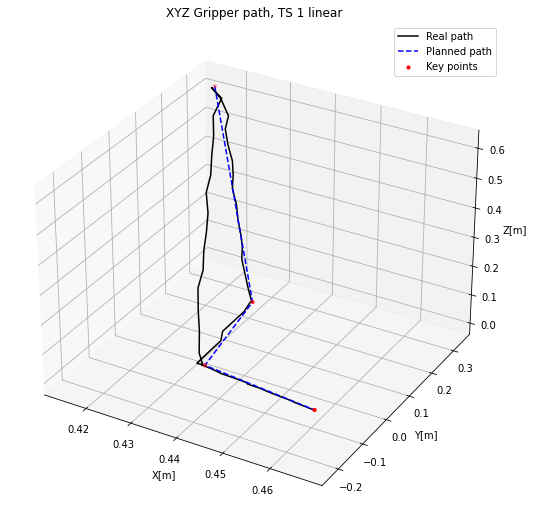

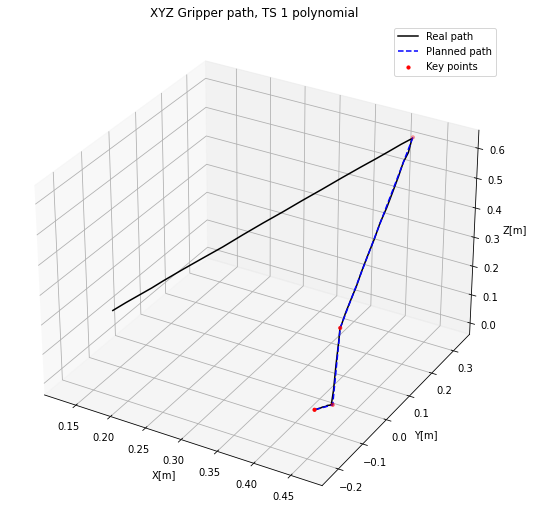

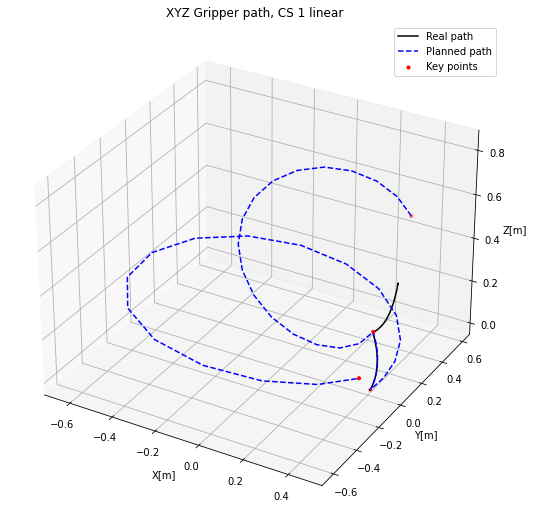

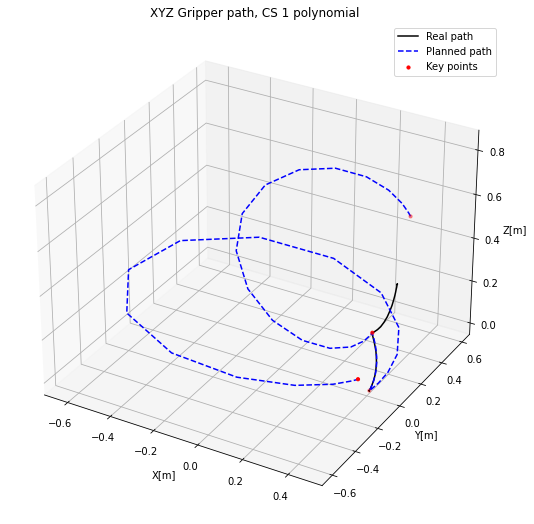

In [8]:
# Path 1

# TS_1 real Linear 
plot_xyz(x_1, real_path[3][1], planned_path_1_L, 'TS 1 linear')

# TS_1 real polynomial 
plot_xyz(x_1, real_path[4][1], planned_path_1, 'TS 1 polynomial')

# # CS_1 real Linear 
plot_xyz(x_1, real_path[0][1], Cplanned_path_1_L, 'CS 1 linear') # stack before point 3

# # CS_1 real Linear 
plot_xyz(x_1, real_path[1][1], Cplanned_path_1, 'CS 1 polynomial') # stack before point 3


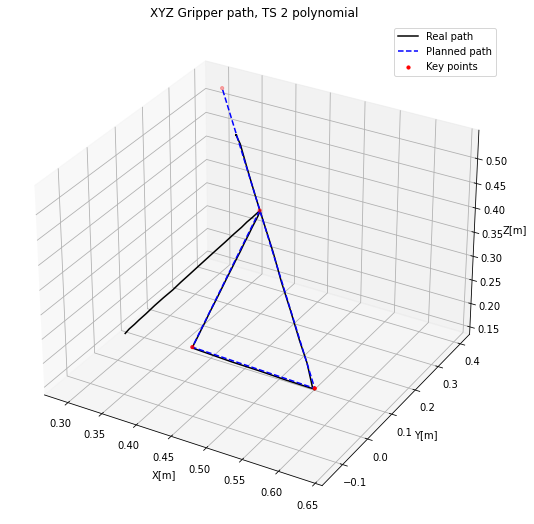

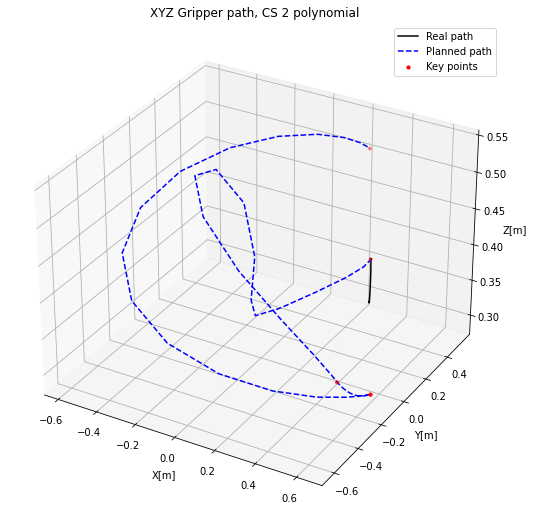

In [9]:
# Path 2

# TS_2 real polynomial 
plot_xyz(x_2, real_path[5][1], planned_path_2, 'TS 2 polynomial')

# CS_2 real polynomial 
plot_xyz(x_2, real_path[2][1], Cplanned_path_2, 'CS 2 polynomial')


In [10]:
# compute error
from sklearn.metrics import mean_squared_error

# TS 1 lin
r_ts1_lin = real_path[3][1]
p_ts1_lin = planned_path_1_L[:,:3]
r_ts1_lin = r_ts1_lin[17:,:]
err_1 = round(mean_squared_error(p_ts1_lin, r_ts1_lin)*100, 4)
print(f'error path 1 TS linear : {err_1}[%]')

# TS 1 pol
r_ts1_pol = real_path[4][1]
p_ts1_pol = planned_path_1[:,:3]
r_ts1_pol = r_ts1_pol[18:,:]
err_2 = round(mean_squared_error(p_ts1_pol, r_ts1_pol)*100, 4)
print(f'error path 1 TS polynomial : {err_2}[%]')

# TS 2 pol
r_ts2_pol = real_path[5][1]
p_ts2_pol = planned_path_2[:54,:3]
r_ts2_pol = r_ts2_pol[19:73,:]
err_3 = round(mean_squared_error(p_ts2_pol, r_ts2_pol)*100, 4)
print(f'error path 2 TS polynomial : {err_3}[mm]')

error path 1 TS linear : 0.7581[%]
error path 1 TS polynomial : 0.6469[%]
error path 2 TS polynomial : 1.4762[mm]
